In [38]:
import os
import sys
sys.path.extend(["../..", "."])

from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, "..", "..")

from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import allign_metrics, report_alligned_metrics, get_roc, get_preds
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict
from nebula.models.neurlux import NeurLuxModel
from nebula.models.quovadis import QuoVadisModel
from nebula.models import TransformerEncoderChunks
from nebula.constants import SPEAKEASY_LABELMAP
REVERSE_SPEAKEASY_LABELMAP = {v: k for k, v in SPEAKEASY_LABELMAP.items()}
from collections import defaultdict
import numpy as np
import pickle
import json
import torch

RUN_TYPES = ["nebula", "neurlux", "quovadis"]
RUN_NAME = "speakeasy"

INFOLDER = "out_speakeasy_multiclass_short"

RUN_END_FILTER = "r1763_t0.5"
run_folders = [x for x in os.listdir(INFOLDER) if x.startswith("cv") and x.endswith(RUN_END_FILTER)]

NEBULA_VOCAB = 5000
NEURLUX_VOCAB = 1000
QUO_VADIS_VOCAB = 600
SEQ_LEN = 512
LIMIT = 500
# TBD -- see:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html


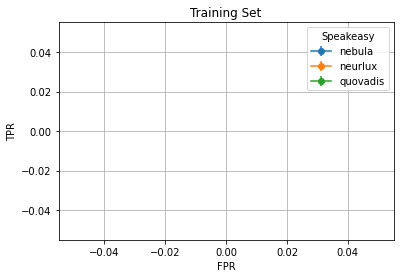

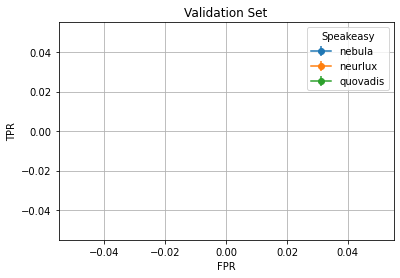

In [2]:
def training_filter(file):
    return file.endswith("training.json")
def validation_filter(file):
    return file.endswith("validation.json")
def key_extractor(file):
    return file.split("_")[0]

metrics_train = {}
metrics_val = {}
for folder in run_folders:
    metrics_train.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, training_filter))
    metrics_val.update(read_cv_metrics_folder(os.path.join(INFOLDER, folder), key_extractor, validation_filter))

TITLE = RUN_NAME.capitalize()
newkeys = [x for x in metrics_train.keys()]
ax = plot_cv_metrics_dict(metrics_train, "tpr", legendTitle=TITLE, legendValues=newkeys)
ax.set_title("Training Set")

ax = plot_cv_metrics_dict(metrics_val, "tpr", legendTitle=TITLE, legendValues=newkeys)
_ = ax.set_title("Validation Set")

In [3]:
models = defaultdict(dict)

neurlux_vocab_file = os.path.join(INFOLDER, f"neurlux_{RUN_NAME}_vocab_{NEURLUX_VOCAB}_seqlen_{SEQ_LEN}", f"vocab_{NEURLUX_VOCAB}.json")
quo_vadis_data_folder = os.path.join(INFOLDER, f"quovadis_{RUN_NAME}_vocab_{QUO_VADIS_VOCAB}_seqlen_{SEQ_LEN}")
quo_vadis_vocab_name = [x for x in os.listdir(quo_vadis_data_folder) if x.startswith("vocab")][0]
quovadis_vocab_file = os.path.join(quo_vadis_data_folder, quo_vadis_vocab_name)
nebula_vocab_file = os.path.join(INFOLDER, f"nebula_{RUN_NAME}_vocab_{NEBULA_VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{NEBULA_VOCAB}_vocab.json")

with open(neurlux_vocab_file) as f:
    neurlux_vocab = json.load(f)
models['neurlux']['class'] = NeurLuxModel
models['neurlux']['config'] = {
    "embedding_dim": 256,
    "vocab_size": len(neurlux_vocab),
    "seq_len": SEQ_LEN,
    "num_classes": 8
}

models['quovadis']['class'] = QuoVadisModel
models['quovadis']['config'] = {
    "vocab": quovadis_vocab_file,
    "seq_len": SEQ_LEN,
    "num_classes": 8
}

with open(nebula_vocab_file) as f:
    nebula_vocab = json.load(f)
models['nebula']['class'] = TransformerEncoderChunks
models['nebula']['config'] = {
    "vocab_size": len(nebula_vocab),
    "maxlen": SEQ_LEN,
    "chunk_size": 64,
    "dModel": 64,  # embedding & transformer dimension
    "nHeads": 8,  # number of heads in nn.MultiheadAttention
    "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
    "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    "numClasses": 8, # binary classification
    "hiddenNeurons": [64],
    "layerNorm": False,
    "dropout": 0.3,
    "mean_over_sequence": False,
    "norm_first": True
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
metrics_val = defaultdict(list)
model_files = defaultdict(list)
for folder in run_folders:
    key = folder.split("_")[1]
    print(f"[*] In process: {key}")

    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_val_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = defaultdict(list)
        folder = os.path.join(INFOLDER, folder)
        data_splits = read_cv_data_splits(folder)
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]
        
        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                data_splits[i]["X_test"],
                data_splits[i]["y_test"],
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            y_pred = np.argmax(y_pred, axis=1)
            n_unique_classes = len(np.unique(y_true))
            for n in range(n_unique_classes):
                label = REVERSE_SPEAKEASY_LABELMAP[n]
                y_true_n = np.where(y_true == n, 1, 0)
                y_pred_n = np.where(y_pred == n, 1, 0)
                fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true_n, y_pred_n, metrics_full=True)
                #print(f"For class {label} metrics are: fpr: {fpr}, tpr: {tpr}, roc_auc: {roc_auc}, f1: {f1}, recall: {recall}, precision: {precision}, acc: {acc}")
                metrics[label].append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        #pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_val[key] = metrics

[*] In process: nebula
[*] Running ROC for split: 0
Evaluating nebula_split_0 | Size: 2517768...


100%|██████████| 2/2 [00:00<00:00,  9.54it/s]


[*] Running ROC for split: 1
Evaluating nebula_split_1 | Size: 2517768...


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[*] Running ROC for split: 2
Evaluating nebula_split_2 | Size: 2517768...


100%|██████████| 2/2 [00:00<00:00, 30.99it/s]

[*] In process: neurlux


[*] Running ROC for split: 0
Evaluating neurlux_split_0 | Size: 490822...


100%|██████████| 2/2 [00:00<00:00, 72.66it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[*] Running ROC for split: 1
Evaluating neurlux_split_1 | Size: 490822...


100%|██████████| 2/2 [00:00<00:00, 76.90it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[*] Running ROC for split: 2
Evaluating neurlux_split_2 | Size: 490822...


100%|██████████| 2/2 [00:00<00:00, 83.32it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[*] In process: quovadis
[*] Running ROC for split: 0
Evaluating quovadis_split_0 | Size: 1449352...


100%|██████████| 2/2 [00:00<00:00, 63.53it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[*] Running ROC for split: 1
Evaluating quovadis_split_1 | Size: 1449352...


100%|██████████| 2/2 [00:00<00:00, 64.92it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[*] Running ROC for split: 2
Evaluating quovadis_split_2 | Size: 1449352...


100%|██████████| 2/2 [00:00<00:00, 65.50it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clean
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.001308  0.843639  0.757191  0.750915   0.767117  0.896027
neurlux   0.001811  0.866451  0.799406  0.778707   0.825658  0.916011
quovadis  0.003288  0.884631  0.836016  0.797254   0.891424  0.934011
backdoor
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.000942  0.823558  0.692380  0.749283   0.651532  0.872087
neurlux   0.001124  0.860469  0.747345  0.797297   0.710238  0.902003
quovadis  0.001539  0.903298  0.817289  0.863230   0.777485  0.928011
coinminer
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.002253  0.870686  0.738639  0.777199   0.717469  0.941984
neurlux   0.004093  0.872049  0.711945  0.793072   0.686772  0.931943
quovadis  0.002094  0.856861  0.726287  0.749566   0.706710  0.942008
dropper
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.001269  0.738498  0.554865  0.532143   0.5941

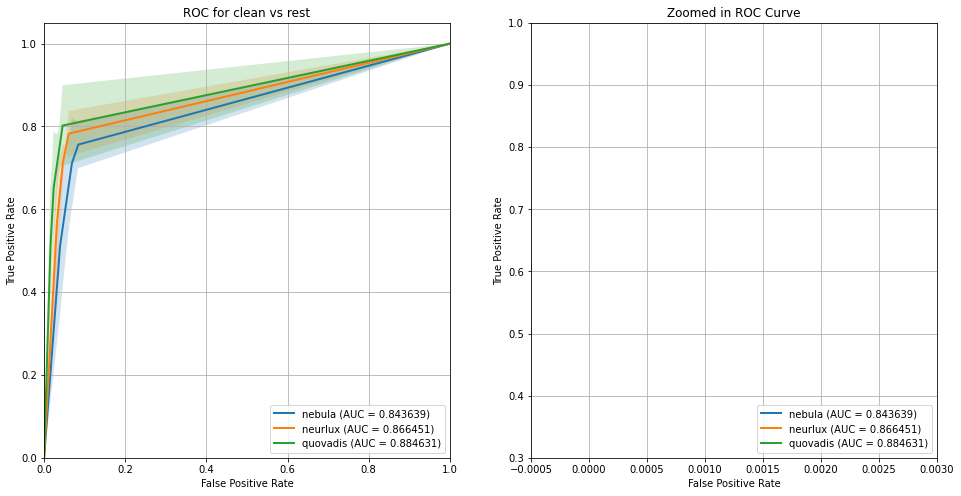

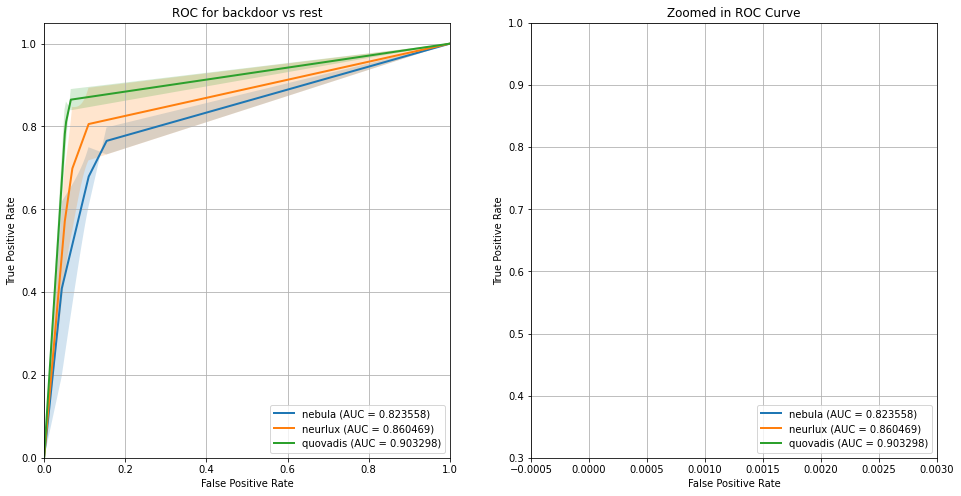

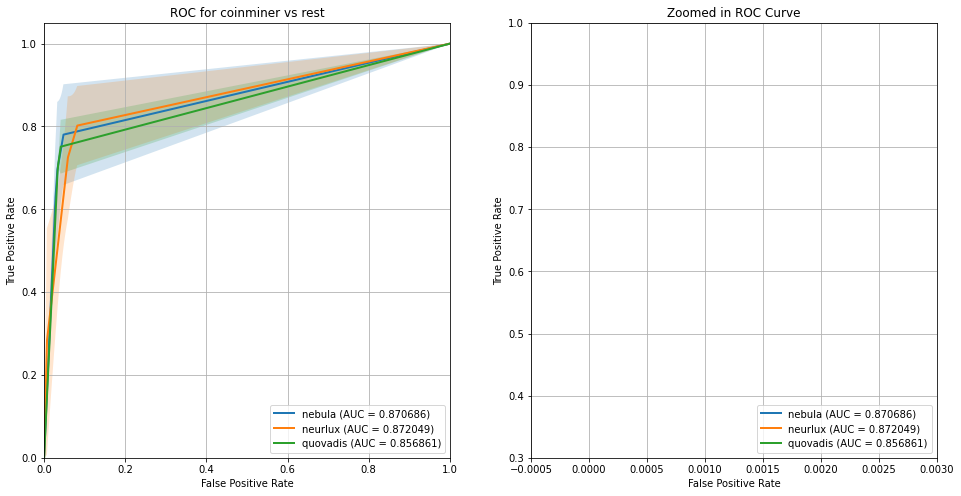

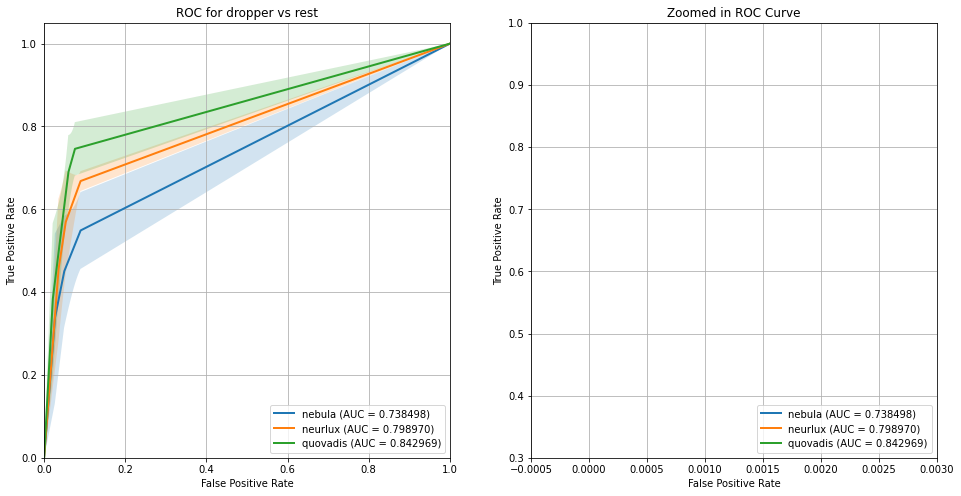

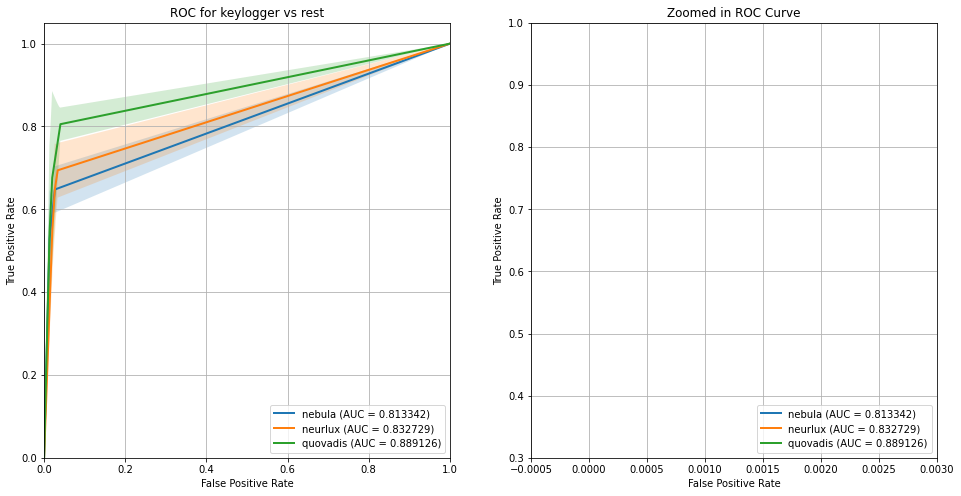

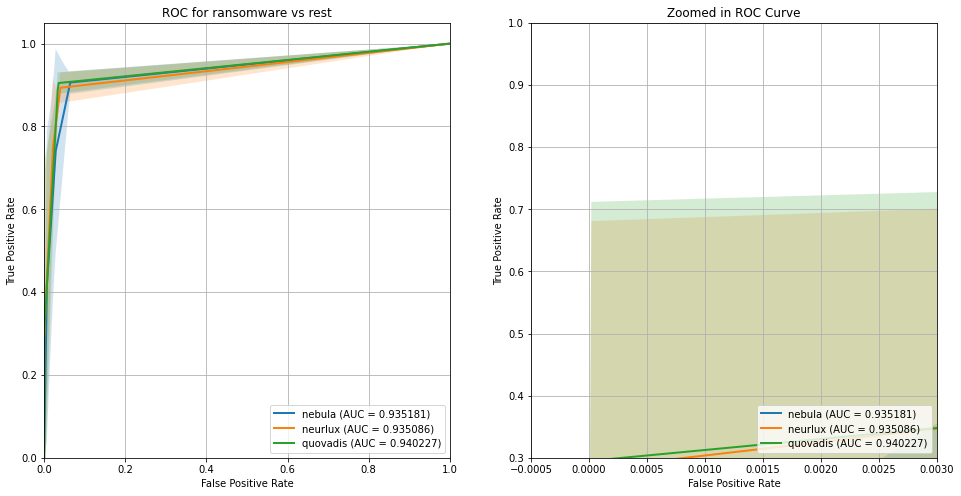

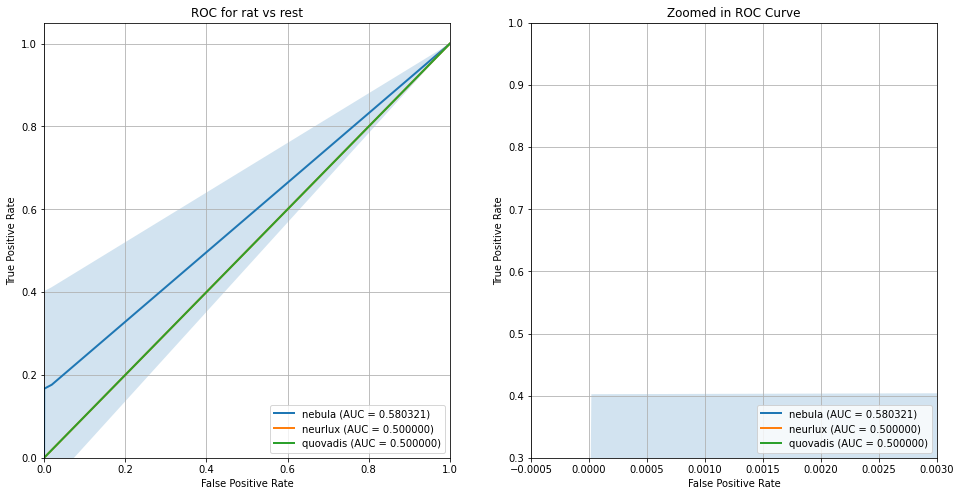

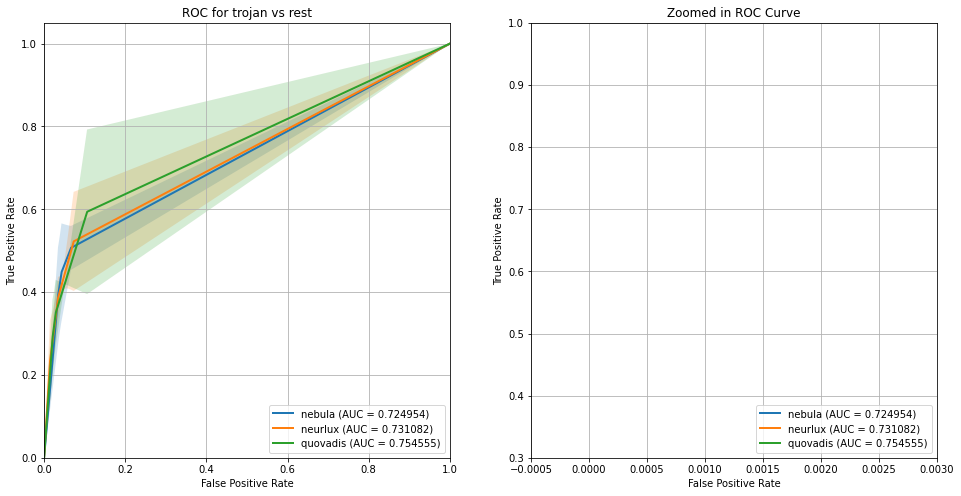

In [63]:
for selected_label in SPEAKEASY_LABELMAP.keys():
    metrics_label = {k: v[selected_label] for k, v in metrics_val.items()}
    base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(metrics_label)

    df, axs_val = report_alligned_metrics(
        base_fpr_val,
        tprs_mean_val,
        tprs_std_val,
        metrics_label,
        xlim=[-0.0005, 0.003],
        ylim=[0.3, 1.0],
        metrics_full=True
    )
    # suptitle to refer label
    axs_val[0].set_title(f"ROC for {selected_label} vs rest")
    print(selected_label)
    print(df[df.columns[0:1].tolist() + df.columns[-5:].tolist()])

## Test set ROCs

In [44]:
metrics_test = defaultdict(list)
model_files = defaultdict(list)
for folder in run_folders:
    key = folder.split("_")[1]
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_test_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = defaultdict(list)
        print(f"[*] In process: {key}")
        folder = os.path.join(INFOLDER, folder)

        data_folder = [x for x in os.listdir(INFOLDER) if x.startswith(key) and "vocab" in x][0]
        X_test = np.load(os.path.join(INFOLDER, data_folder, f"x_test_{LIMIT}.npy"))
        y_test = np.load(os.path.join(INFOLDER, data_folder, f"y_test_{LIMIT}.npy"))

        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]

        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                X_test,
                y_test,
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            y_pred = np.argmax(y_pred, axis=1)
            n_unique_classes = len(np.unique(y_true))
            for n in range(n_unique_classes):
                label = REVERSE_SPEAKEASY_LABELMAP[n]
                y_true_n = np.where(y_true == n, 1, 0)
                y_pred_n = np.where(y_pred == n, 1, 0)
                fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true_n, y_pred_n, metrics_full=True)
                print(f"For class {label} metrics are: fpr: {fpr}, tpr: {tpr}, roc_auc: {roc_auc}, f1: {f1}, recall: {recall}, precision: {precision}, acc: {acc}")
                metrics[label].append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        #pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_test[key] = metrics

[*] In process: nebula
[*] Running ROC for split: 0
Evaluating nebula_split_0 | Size: 2517768...


100%|██████████| 25/25 [00:01<00:00, 24.88it/s]


For class clean metrics are: fpr: [0.         0.16127321 1.        ], tpr: [0.         0.73684211 1.        ], roc_auc: 0.7877844478570432, f1: 0.6131386861313869, recall: 0.7368421052631579, precision: 0.525, acc: 0.8188808201623238
For class backdoor metrics are: fpr: [0.         0.25575448 1.        ], tpr: [0.         0.76943005 1.        ], roc_auc: 0.7568377880550734, f1: 0.5021132713440406, recall: 0.7694300518134715, precision: 0.3726474278544542, acc: 0.7483981204613414
For class coinminer metrics are: fpr: [0.         0.05541687 1.        ], tpr: [0.         0.16568047 1.        ], roc_auc: 0.5551317993424064, f1: 0.2217821782178218, recall: 0.16568047337278108, precision: 0.33532934131736525, acc: 0.832123024348569
For class dropper metrics are: fpr: [0.         0.04313725 1.        ], tpr: [0.         0.13043478 1.        ], roc_auc: 0.5436487638533674, f1: 0.07947019867549669, recall: 0.13043478260869565, precision: 0.05714285714285714, acc: 0.9406236651003844
For class ke

100%|██████████| 25/25 [00:00<00:00, 35.26it/s]


For class clean metrics are: fpr: [0.         0.21803714 1.        ], tpr: [0.         0.73684211 1.        ], roc_auc: 0.7594024849923217, f1: 0.5586034912718204, recall: 0.7368421052631579, precision: 0.4497991967871486, acc: 0.7731738573259291
For class backdoor metrics are: fpr: [0.         0.23580563 1.        ], tpr: [0.         0.74611399 1.        ], roc_auc: 0.7551541815194202, f1: 0.507488986784141, recall: 0.7461139896373057, precision: 0.38451268357810414, acc: 0.7612131567706109
For class coinminer metrics are: fpr: [0.         0.10484274 1.        ], tpr: [0.         0.44970414 1.        ], roc_auc: 0.6724307030578394, f1: 0.4342857142857143, recall: 0.44970414201183434, precision: 0.4198895027624309, acc: 0.8308415207176421
For class dropper metrics are: fpr: [0.         0.03703704 1.        ], tpr: [0.         0.15217391 1.        ], roc_auc: 0.5575684380032206, f1: 0.10144927536231885, recall: 0.15217391304347827, precision: 0.07608695652173914, acc: 0.9470311832550192

100%|██████████| 25/25 [00:00<00:00, 35.05it/s]


For class clean metrics are: fpr: [0.         0.19469496 1.        ], tpr: [0.         0.63377193 1.        ], roc_auc: 0.71953848480618, f1: 0.5197841726618705, recall: 0.6337719298245614, precision: 0.4405487804878049, acc: 0.7718923536950021
For class backdoor metrics are: fpr: [0.         0.17033248 1.        ], tpr: [0.         0.69689119 1.        ], roc_auc: 0.7632793554457151, f1: 0.5445344129554657, recall: 0.6968911917098446, precision: 0.446843853820598, acc: 0.8077744553609568
For class coinminer metrics are: fpr: [0.         0.07438842 1.        ], tpr: [0.         0.34319527 1.        ], roc_auc: 0.6344034244491252, f1: 0.384742951907131, recall: 0.3431952662721893, precision: 0.4377358490566038, acc: 0.8415207176420333
For class dropper metrics are: fpr: [0.         0.09237473 1.        ], tpr: [0.         0.32608696 1.        ], roc_auc: 0.6168561144264469, f1: 0.10989010989010989, recall: 0.32608695652173914, precision: 0.06607929515418502, acc: 0.8961982058949167
For 

100%|██████████| 25/25 [00:00<00:00, 90.75it/s]


For class clean metrics are: fpr: [0.         0.06949602 1.        ], tpr: [0.         0.76535088 1.        ], roc_auc: 0.8479274279864116, f1: 0.7457264957264957, recall: 0.7653508771929824, precision: 0.7270833333333333, acc: 0.898334045279795
For class backdoor metrics are: fpr: [0.         0.17647059 1.        ], tpr: [0.         0.77720207 1.        ], roc_auc: 0.800365742151783, f1: 0.5819592628516004, recall: 0.7772020725388601, precision: 0.46511627906976744, acc: 0.8158906450234943
For class coinminer metrics are: fpr: [0.         0.05042436 1.        ], tpr: [0.         0.13609467 1.        ], roc_auc: 0.5428351555506976, f1: 0.18969072164948453, recall: 0.13609467455621302, precision: 0.3129251700680272, acc: 0.832123024348569
For class dropper metrics are: fpr: [0.         0.10239651 1.        ], tpr: [0.         0.34782609 1.        ], roc_auc: 0.6227147863976509, f1: 0.10774410774410774, recall: 0.34782608695652173, precision: 0.06374501992031872, acc: 0.8868005126014523


100%|██████████| 25/25 [00:00<00:00, 88.86it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For class clean metrics are: fpr: [0.         0.23819629 1.        ], tpr: [0.        0.8377193 1.       ], roc_auc: 0.7997615058867328, f1: 0.5936285936285937, recall: 0.8377192982456141, precision: 0.45968712394705175, acc: 0.7765912003417343
For class backdoor metrics are: fpr: [0.         0.11202046 1.        ], tpr: [0.         0.63471503 1.        ], roc_auc: 0.7613472827743397, f1: 0.5764705882352941, recall: 0.6347150259067358, precision: 0.5280172413793104, acc: 0.8462195642887654
For class coinminer metrics are: fpr: [0.         0.14378432 1.        ], tpr: [0.         0.76035503 1.        ], roc_auc: 0.8082853530355354, f1: 0.5821064552661381, recall: 0.7603550295857988, precision: 0.47155963302752296, acc: 0.8423750533959846
For class dropper metrics are: fpr: [0.         0.04923747 1.        ], tpr: [0.         0.36956522 1.        ], roc_auc: 0.6601638723122099, f1: 0.19318181818181818, recall: 0.3695652173913043, precision: 0.13076923076923078, acc: 0.9393421614694575
Fo

100%|██████████| 25/25 [00:00<00:00, 85.91it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For class clean metrics are: fpr: [0.        0.2403183 1.       ], tpr: [0.         0.61622807 1.        ], roc_auc: 0.6879548838940853, f1: 0.47226890756302525, recall: 0.6162280701754386, precision: 0.38283378746594005, acc: 0.7317385732592909
For class backdoor metrics are: fpr: [0.         0.08235294 1.        ], tpr: [0.         0.64766839 1.        ], roc_auc: 0.7826577263029564, f1: 0.6273525721455459, recall: 0.6476683937823834, precision: 0.6082725060827251, acc: 0.8731311405382315
For class coinminer metrics are: fpr: [0.        0.1123315 1.       ], tpr: [0.         0.67159763 1.        ], roc_auc: 0.7796330651951068, f1: 0.5746835443037975, recall: 0.6715976331360947, precision: 0.5022123893805309, acc: 0.8564715933361812
For class dropper metrics are: fpr: [0.         0.05359477 1.        ], tpr: [0.         0.34782609 1.        ], roc_auc: 0.6471156578573458, f1: 0.17297297297297298, recall: 0.34782608695652173, precision: 0.11510791366906475, acc: 0.9346433148227253
For 

100%|██████████| 25/25 [00:00<00:00, 58.63it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For class clean metrics are: fpr: [0.         0.02970822 1.        ], tpr: [0.         0.66666667 1.        ], roc_auc: 0.8184792219274977, f1: 0.7450980392156862, recall: 0.6666666666666666, precision: 0.8444444444444444, acc: 0.9111490815890645
For class backdoor metrics are: fpr: [0.         0.07007673 1.        ], tpr: [0.         0.60362694 1.        ], roc_auc: 0.7667751083312351, f1: 0.6164021164021165, recall: 0.6036269430051814, precision: 0.6297297297297297, acc: 0.8761213156770611
For class coinminer metrics are: fpr: [0.         0.09236146 1.        ], tpr: [0.         0.36390533 1.        ], roc_auc: 0.6357719338152534, f1: 0.38080495356037153, recall: 0.363905325443787, precision: 0.39935064935064934, acc: 0.8291328492097394
For class dropper metrics are: fpr: [0.         0.13376906 1.        ], tpr: [0.         0.47826087 1.        ], roc_auc: 0.6722459031921947, f1: 0.11733333333333333, recall: 0.4782608695652174, precision: 0.0668693009118541, acc: 0.8586074327210593
F

100%|██████████| 25/25 [00:00<00:00, 71.75it/s]
C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For class clean metrics are: fpr: [0.         0.09973475 1.        ], tpr: [0.         0.78947368 1.        ], roc_auc: 0.8448694680999581, f1: 0.7171314741035856, recall: 0.7894736842105263, precision: 0.656934306569343, acc: 0.878684322938915
For class backdoor metrics are: fpr: [0.         0.02710997 1.        ], tpr: [0.        0.5984456 1.       ], roc_auc: 0.7856678107151849, f1: 0.6895522388059702, recall: 0.5984455958549223, precision: 0.8133802816901409, acc: 0.9111490815890645
For class coinminer metrics are: fpr: [0.         0.06440339 1.        ], tpr: [0.         0.59763314 1.        ], roc_auc: 0.7666148705935181, f1: 0.6038863976083707, recall: 0.5976331360946746, precision: 0.6102719033232629, acc: 0.8868005126014523
For class dropper metrics are: fpr: [0.         0.16034858 1.        ], tpr: [0.         0.69565217 1.        ], roc_auc: 0.7676517950175238, f1: 0.14349775784753366, recall: 0.6956521739130435, precision: 0.08, acc: 0.8368218709953011
For class keylogger m

100%|██████████| 25/25 [00:00<00:00, 73.72it/s]

For class clean metrics are: fpr: [0.         0.13687003 1.        ], tpr: [0.         0.69736842 1.        ], roc_auc: 0.7802491972637162, f1: 0.6162790697674418, recall: 0.6973684210526315, precision: 0.5520833333333334, acc: 0.8308415207176421
For class backdoor metrics are: fpr: [0.         0.01534527 1.        ], tpr: [0.        0.5984456 1.       ], roc_auc: 0.7915501636563613, f1: 0.7140649149922721, recall: 0.5984455958549223, precision: 0.8850574712643678, acc: 0.9209739427595045
For class coinminer metrics are: fpr: [0.         0.09935097 1.        ], tpr: [0.         0.56213018 1.        ], roc_auc: 0.7313896019875512, f1: 0.5226960110041265, recall: 0.5621301775147929, precision: 0.4884318766066838, acc: 0.8517727466894489
For class dropper metrics are: fpr: [0.         0.21830065 1.        ], tpr: [0.         0.39130435 1.        ], roc_auc: 0.5865018471156578, f1: 0.06371681415929203, recall: 0.391304347826087, precision: 0.03468208092485549, acc: 0.7740281930798804
For c


C:\Users\dtrizna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clean
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.000373  0.755575  0.563842  0.702485   0.471783  0.787982
neurlux   0.000570  0.778548  0.603875  0.739766   0.523201  0.802221
quovadis  0.001182  0.814533  0.692836  0.717836   0.684487  0.873558
backdoor
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.000342  0.758424  0.518046  0.737478   0.401335  0.772462
neurlux   0.000598  0.781457  0.595261  0.686528   0.533802  0.845080
quovadis  0.002323  0.781331  0.673340  0.600173   0.776056  0.902748
coinminer
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.000396  0.620655  0.346937  0.319527   0.397652  0.834828
neurlux   0.000466  0.710251  0.448827  0.522682   0.428899  0.843657
quovadis  0.000629  0.711259  0.502462  0.507890   0.499351  0.855902
dropper
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.000355  0.572691  0.096937  0.202899   0.0664

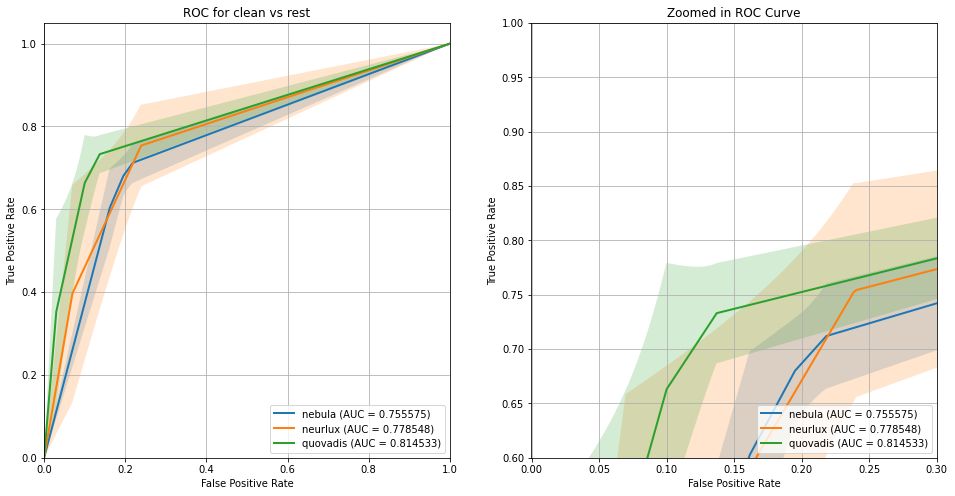

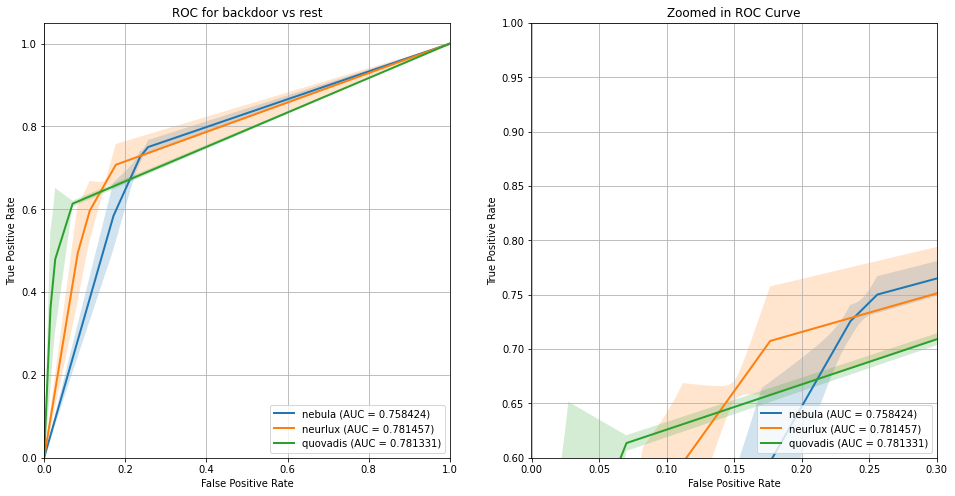

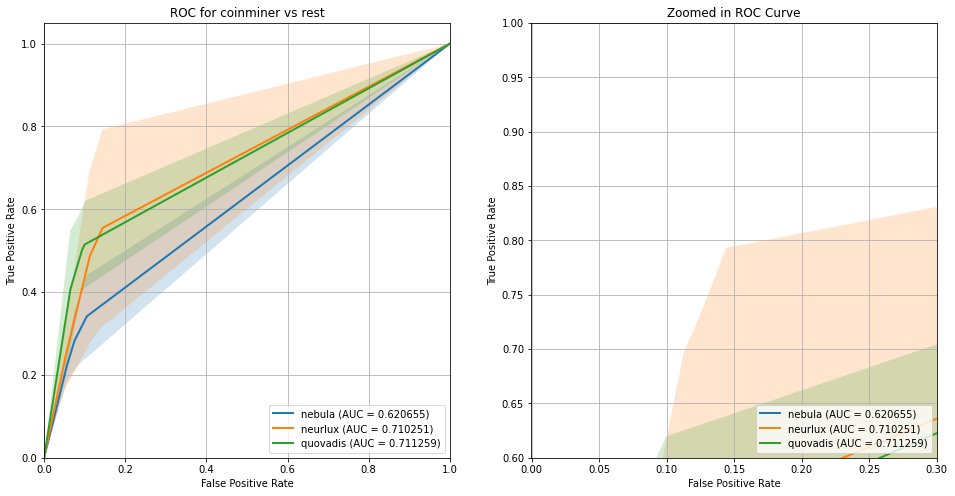

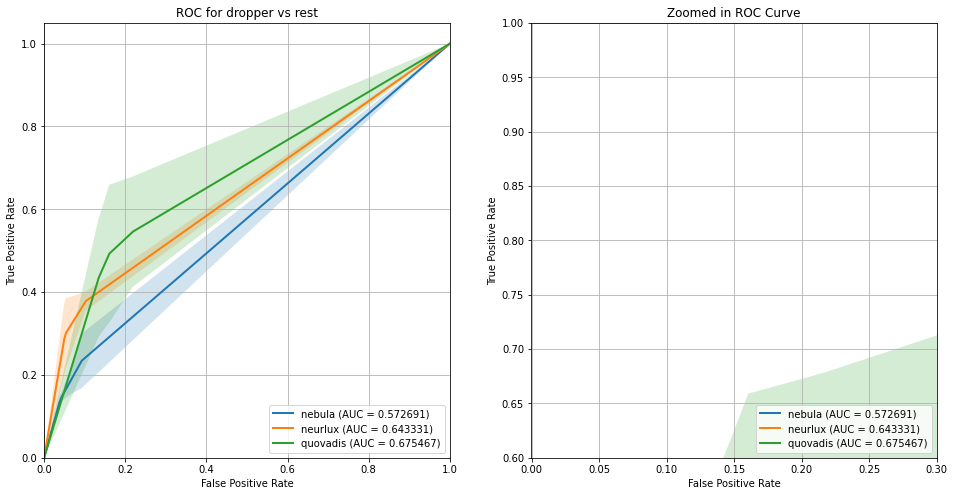

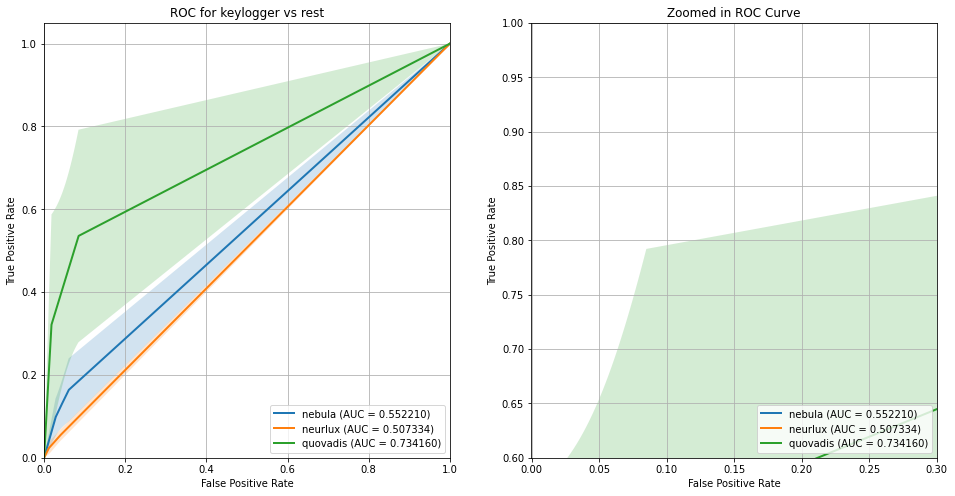

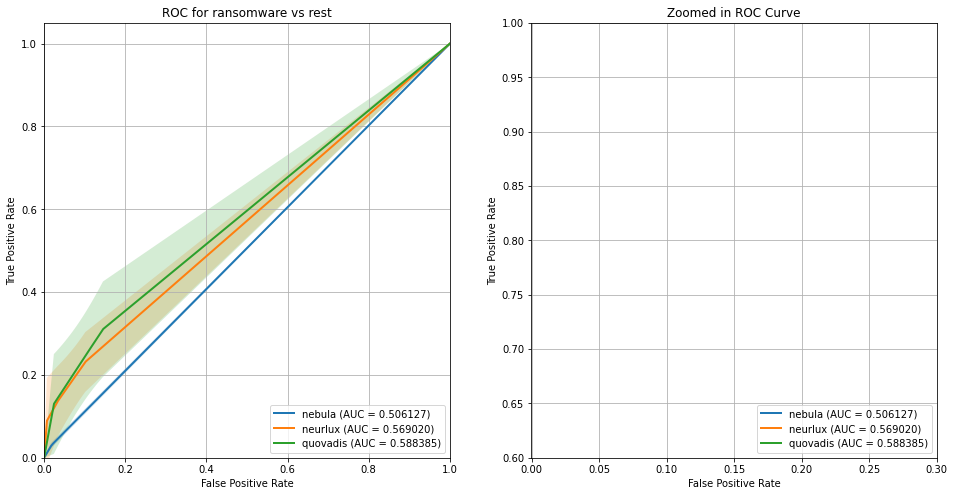

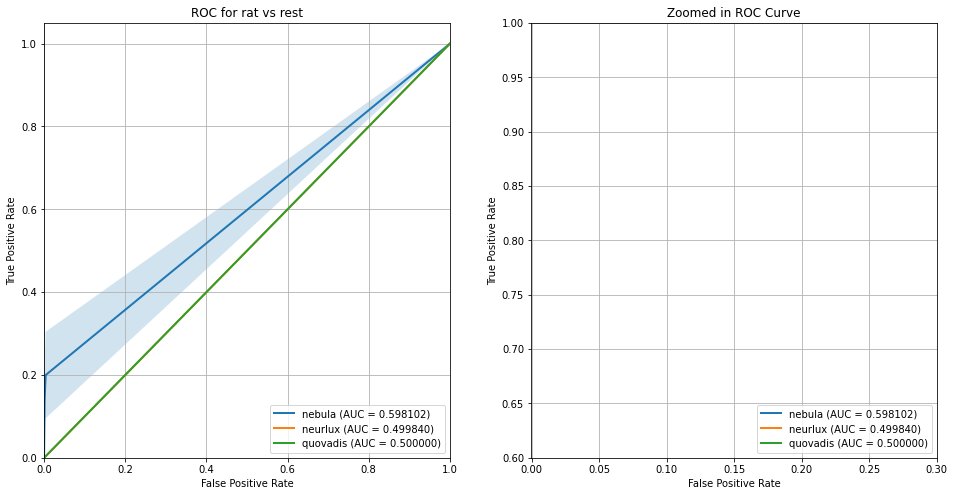

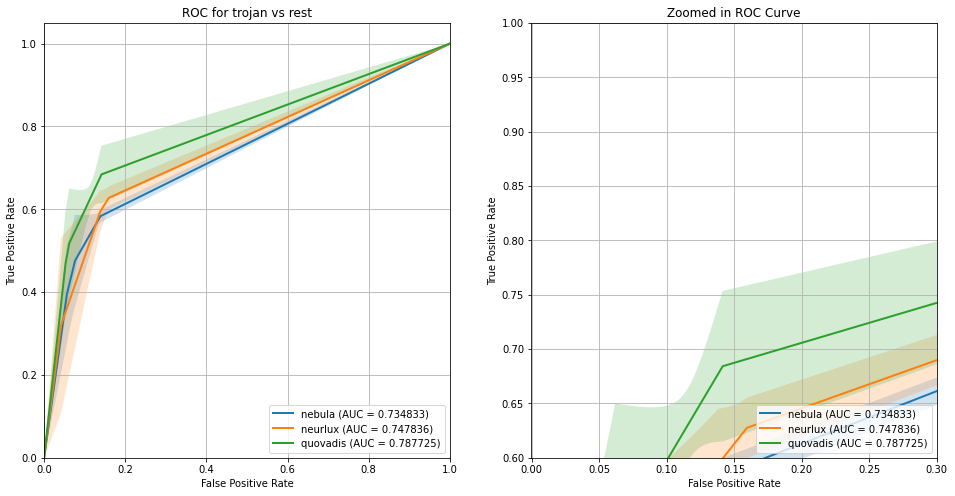

In [62]:
for selected_label in SPEAKEASY_LABELMAP.keys():
    metrics_label = {k: v[selected_label] for k, v in metrics_test.items()}
    base_fpr_test, tprs_mean_test, tprs_std_test = allign_metrics(metrics_label)

    df, axs_test = report_alligned_metrics(
        base_fpr_test,
        tprs_mean_test,
        tprs_std_test,
        metrics_label,
        metrics_full=True
    )
    # suptitle to refer label
    axs_test[0].set_title(f"ROC for {selected_label} vs rest")
    print(selected_label)
    print(df[df.columns[0:1].tolist() + df.columns[-5:].tolist()])